# Activity 3.2 Logistic Regression
(last modified 30 Mar 2023)

### Learning Outcomes

In this activity you learn to

- define and motivate the sigmoid activation function for logistic regression
- use the template of `scikit-learn` for classification models
- fit a logistic regression model using Stochastic Gradient Dessent (SGD) 
- describe the weakness of logistic regression for linearly seperable data and how to address it via regularisation

In Assignment 1, you will compare logistic regression with the Bayesian generative classifier.

### Prerequisites

- Basics of `numpy` and `scikit-learn`
- Basics of probabilistic models (Lecture 2)
- Stochastic gradient descent (Lecture 3)
- Definition of logistic regression model (Lecture 5)

## The Logistic Regression Model for Classification

The **logistic regression model** for binary classification (target values $T \in \{0, 1\}$) is a generalised linear model, i.e., it makes predictions of the form 
$$y(\boldsymbol{x}) = f(a(\boldsymbol{x}))$$
where $a(\boldsymbol{x})=\boldsymbol{w}^T\boldsymbol{x}$ is a **linear (discriminant) function** with parameters $\boldsymbol{w}$ and $f$ is an **activation function** (also called 'inverse link function' in statistics).

In particular, the main idea of logistic regression is that the value of the linear function $a(\boldsymbol{x})$ describes the **log odds** of the positive class given $\boldsymbol{x}$, i.e.,
$$
a(\boldsymbol{x}) = \boldsymbol{w}^T\boldsymbol{x} = \ln \frac{p(T=1 | X=\boldsymbol{x})}{p(T=0 | X=\boldsymbol{x})} \enspace.
$$
This means that logistic regression is a probabilistic model describing the conditional probability of the target variable $T$ given $X$. As mentioned during the lectures, we can always use a probabilistic model to make predictions via
$$
y(\boldsymbol{x}) = E[T | X=\boldsymbol{x}] = p(T = 1 | X = \boldsymbol{x}) \enspace
$$
As our prediction is $y(\boldsymbol{x}) = f(a(\boldsymbol{x}))$, the activation function has to map the log odds to the conditional probability of $T=1$. This is achieved by defining $f$ to be the (logistic) **sigmoid function**:
$$
\sigma(a) = \frac{1}{1+\exp(-a)} \enspace .
$$

Let us visualise this sigmoid transformation and the prediction function corresponding to a specific weight vector. Below we use $\boldsymbol{w}=(1, 0.5)$ as an example, but we encourage you to try out other values.

#### Task A: Implement Sigmoid Function

**Give a `numpy`-implementation (without loops) for the sigmoid function below that maps an array of floats to an array of the component-wise sigmoid values.**

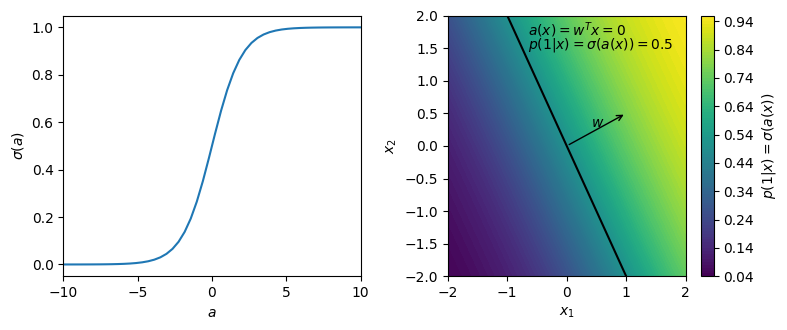

In [1]:
import numpy as np
from matplotlib import pyplot as plt

def sigmoid(a):
    return 1/(1+np.exp(-a))

w = np.array([1, 0.5])

_, axs = plt.subplots(1, 2, figsize=(8, 3.4), tight_layout=True)
aa = np.linspace(-10, 10)
axs[0].plot(aa, sigmoid(aa))
axs[0].margins(x=0)
axs[0].set_xlabel('$a$')
axs[0].set_ylabel('$\sigma(a)$')

xx1, xx2 = np.meshgrid(np.linspace(-2, 2, 200), np.linspace(-2, 2, 200))
xx = np.dstack((xx1, xx2))
cp = axs[1].contourf(xx1, xx2, sigmoid(xx.dot(w)), levels=100)
axs[1].annotate("", xy=(1, 0.5), xytext=(0, 0), arrowprops=dict(arrowstyle="->"))
axs[1].text(0.4, 0.25, '$w$', va='bottom')
axs[1].text(-0.65, 1.7, '$a(x)=w^Tx=0$')
axs[1].text(-0.65, 1.5, '$p(1|x)=\sigma(a(x))=0.5$')
axs[1].contour(xx1, xx2, sigmoid(xx.dot(w)), levels=[0.5], colors='black')
plt.colorbar(cp, label='$p(1|x)=\sigma(a(x))$', ax=axs[1])
axs[1].set_xlabel('$x_1$')
axs[1].set_ylabel('$x_2$')
plt.show()

## An Error Function for Logistic Regression

We introduced the (predictive) classification problem as having the goal to minimise the expected 0/1-loss and then mentioned that the Perceptron algorithm can be regarded as minimising the distances of wrong-classified data points from the decision boundary. We can write these two losses as functions of the linear discriminant values $a$ as follows:
\begin{align*}
l_\mathrm{0/1}(t, a) &= 
\begin{cases}
1 &, \text{ if } t=1 \text{ and } a<0 \text{ or } t=0 \text{ and } a\geq1\\
0 &, \text{ otherwise }
\end{cases}
= t\delta(a < 0) + (1-t)\delta(a \geq 0)\\
l_\mathrm{perc}(t, a) &=
\begin{cases}
|a| &, \text{ if }t=1 \text{ and } a<0 \text{ or } t=0 \text{ and } a\geq1\\
0 &, \text{ otherwise }
\end{cases}
= -t\delta(a < 0)a + (1-t) \delta(a\geq 0)a 
\end{align*}

Note how the compact forms on the right-hand-side can both be easily implemented in `numpy` (see below). Now for the logistic regression model we can derive a suitable loss function by again invoking the maximum-likelihood principle. If we define the loss function as the negative log likelihood of a data points, we can minimise the sum of these losses for a given training dataset to find the maximum likelihood parameter values. 

By the definition of the logistic regression model, this negative log likelihood is described by the following function:
$$
l_\mathrm{log}(t, a) = 
\begin{cases}
- \ln \sigma(a) &, \text{ if } t=1\\
- \ln (1-\sigma(a)) &, \text{ if } t=0\\
\end{cases}
$$

#### Task B: Compare Loss Functions

**Give a `numpy` implementation of the logistic loss function in $a$ below and then describe what differences between the three loss function you see in the plot that will have an impact on the model fit.**

*The logistic loss is smooth, which will simplify minimisation. Moreover, it assigns a non-zero loss even if a data point is on the right side of the decision boundary. Therefore, when fitting with respect to the logistic loss we are not content with having merely all points correctly classified, we also want to maximise the magnitude of the discriminant values.*

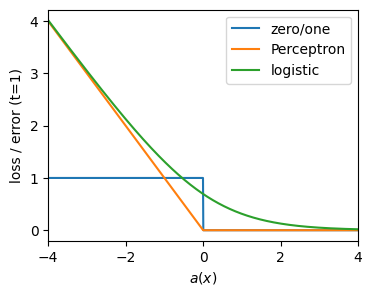

In [2]:
def zo_loss(t, a):
    return t*(a<0) + (1-t)*(a>=0)

def perceptron_loss(t, a):
    return -t*(a<0)*a + (1-t)*(a>=0)*a

def logistic_loss(t, a):
    return -t*np.log(sigmoid(a))-(1-t)*np.log(1-sigmoid(a))

aa = np.linspace(-4, 4, 1000, endpoint=True)
plt.subplots(1, 1, figsize=(4, 3))
plt.plot(aa, zo_loss(1, aa), label='zero/one')
plt.plot(aa, perceptron_loss(1, aa), label='Perceptron')
plt.plot(aa, logistic_loss(1, aa), label='logistic')
plt.margins(x=0)
plt.xlabel('$a(x)$')
plt.ylabel('loss / error (t=1)')
plt.legend()
plt.show()

## Dataset
Similar to Activities 3.1 and 3.2, we generate a synthetic dataset and learn the model based on that.

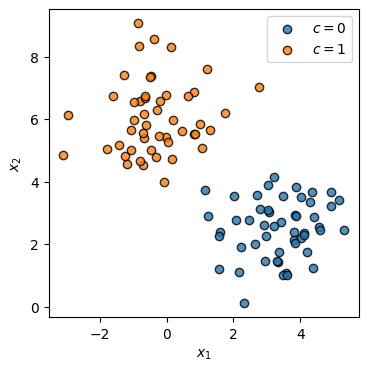

In [3]:
from activity3 import make_gaussian_mixture_data, scatter_data_by_target_value

p0 = 0.60; p1 = 1 - p0
class_probs = [p0, p1] 
mu0 = np.array([3.5, 2.5])
mu1 = np.array([0.0, 6.0])

n = 100
x_train, y_train = make_gaussian_mixture_data(n, [mu0, mu1], class_probs=class_probs, random_state=0)
plt.figure(figsize=(4, 4))
scatter_data_by_target_value(x_train, y_train)
plt.show()

## Stochastic Gradient Descent for Logistic Regression

Equipped with the loss function for individual data points and given a training dataset $(x_1, t_1),\dots, (x_N, t_N)$ we can now implement an algorithm for fitting the weights $\boldsymbol{w}$ by minimising the sum of errors:
$$
E(\boldsymbol{w}) = \sum_{n=1}^N -t_n \ln \sigma(\boldsymbol{w}^T\boldsymbol{x_n}) - (1-t_n)\ln (1-\sigma(\boldsymbol{w}^T\boldsymbol{x_n})) \enspace .
$$

We will again resort to our workhorse, the stochastic gradient descent algorithm. In the lecture we have shown that the gradient of the error function is given as:
\begin{align*}
\nabla E(\boldsymbol{w}) &= -\sum_{n=1}^N (t_n - \sigma(\boldsymbol{w}^T\boldsymbol{x_n})) \boldsymbol{x}_n \\
&=\boldsymbol{X}^T(\sigma(\boldsymbol{X}\boldsymbol{w})-\boldsymbol{t})
\end{align*}
where $\boldsymbol{t}=(t_1, \dots, t_N)$ is vector of target values, $\boldsymbol{X}$ is the data matrix with row $n$ corresponding to $\boldsymbol{x}_n$, and $\sigma(\boldsymbol{X}\boldsymbol{w})=(\sigma(\boldsymbol{x_1} \cdot \boldsymbol{w}), \dots, \sigma(\boldsymbol{x_N} \cdot \boldsymbol{w}))$ is the component-wise application of the sigmoid function.

This last form of the gradient does not only look revealingly similar to the weight gradient in linear regression (the only difference being the application of the sigmoid function), it also allows an efficient `numpy` implementation using matrix/vector-mutplication and the component-wise application of the sigmoid function.

#### Task C: Complete Stochastic Gradient Implementation

***Complete the line below that computes the gradient of the error function evaluated at `w_old`***

Hint: Given the similarity of the gradient to least squares, you might want to check the implementation in Activity 2 in case you are stuck.

In [4]:
class SGDLogisticRegressionClassifier:

    def __init__(self, batch_size=1, eta=0.001, tau_max=10000, epsilon=0.00001, random_state=None):
        self.eta = eta
        self.tau_max = tau_max
        self.epsilon = epsilon
        self.random_state = random_state
        self.batch_size = batch_size
        
    def fit(self, x, y):
        RNG = np.random.default_rng(self.random_state)
        n, p = x.shape
        self.w_ = np.zeros(shape=(self.tau_max+1, p))
        for tau in range(1, self.tau_max+1):
            w_old = self.w_[tau-1]
            idx = RNG.choice(n, size=self.batch_size, replace=True)
            x_batch = x[idx]
            y_batch = y[idx]
            grad = x_batch.T.dot(sigmoid(x_batch.dot(w_old))-y_batch)
            self.w_[tau] = w_old - self.eta*grad
            if np.linalg.norm(self.w_[tau]-w_old) < self.epsilon:
                break
        self.coef_ = self.w_[tau] 
        self.w_ = self.w_[:tau+1]
        return self

    def decision_function(self, x):
        return x.dot(self.coef_)

    def predict(self, x):
        return (self.decision_function(x) > 0).astype(int)
    
    def predict_proba(self, x):
        p1 = sigmoid(self.decision_function(x))
        return np.column_stack((1-p1, p1))


## The `scikit-learn`-template for Classifiers

In the implementation above you can note a couple of conventations that are generally fulfilled by `scikit-learn` classifiers:

- Instead of returning the estimated probabilities as described above, the `predict` method returns actually attainable guesses for the target values, i.e., 0 or 1, which makes sense for using it with 0/1-error. 
- To access the modelled class probabilities, one has to use `predict_proba`, which returns for each input a vector containing the probabilities of each class (in the case of binary classification problems this contains exactly two entries).
- Additionally, `decision_function` provides access to the discriminant function.

Let us fit a logistic regression model to the training data and have a look at the learned parameter vector and its training and test peformance.

In [5]:
logistic_regression = SGDLogisticRegressionClassifier(eta=0.001, batch_size=100, tau_max=10000, random_state=0)
logistic_regression.fit(x_train, y_train)
logistic_regression.coef_

array([-3.80859142,  1.45525864])

In [6]:
from sklearn.metrics import zero_one_loss, log_loss

x_test, y_test = make_gaussian_mixture_data(n=1000, means=[mu0, mu1], random_state=1)

train_01_loss = zero_one_loss(y_train, logistic_regression.predict(x_train))
test_01_loss = zero_one_loss(y_test, logistic_regression.predict(x_test))
train_log_loss = log_loss(y_train, logistic_regression.predict_proba(x_train))
test_log_loss = log_loss(y_test, logistic_regression.predict_proba(x_test))

train_01_loss, test_01_loss, train_log_loss, test_log_loss

(0.020000000000000018,
 0.007000000000000006,
 0.03143497591490689,
 0.021907299729399206)

Since we have again tracked the weight vectors during optimisation, we can plot the learning process.

In [7]:
lr_train_log_losses = [log_loss(y_train, sigmoid(x_train.dot(logistic_regression.w_[tau]))) for tau in range(len(logistic_regression.w_))]
lr_test_log_losses = [log_loss(y_test, sigmoid(x_test.dot(logistic_regression.w_[tau]))) for tau in range(len(logistic_regression.w_))]
lr_train_01_losses = [zero_one_loss(y_train, (x_train.dot(logistic_regression.w_[tau])>=0)) for tau in range(len(logistic_regression.w_))]
lr_test_01_losses = [zero_one_loss(y_test, (x_test.dot(logistic_regression.w_[tau])>=0)) for tau in range(len(logistic_regression.w_))]

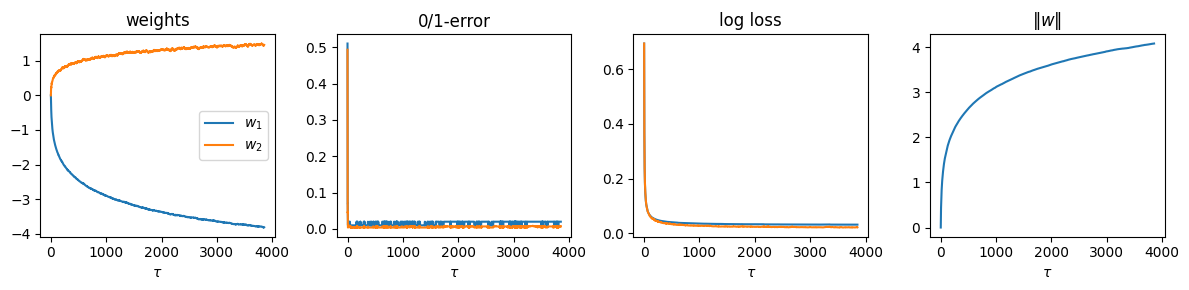

In [8]:
_, axs = plt.subplots(1, 4, tight_layout=True, figsize=(12, 3))

axs[0].set_title('weights')
axs[0].plot(logistic_regression.w_[:, 0], label='$w_1$')
axs[0].plot(logistic_regression.w_[:, 1], label='$w_2$')
axs[0].legend()
axs[0].set_xlabel('$\\tau$')

axs[1].set_title('0/1-error')
axs[1].plot(lr_train_01_losses, label='train')
axs[1].plot(lr_test_01_losses, label='test')
axs[1].set_xlabel('$\\tau$')

axs[2].set_title('log loss')
axs[2].plot(lr_train_log_losses, label='train')
axs[2].plot(lr_test_log_losses, label='test')
axs[2].set_xlabel('$\\tau$')

axs[3].set_title('$\|w\|$')
axs[3].plot(np.linalg.norm(logistic_regression.w_, axis=1))
axs[3].set_xlabel('$\\tau$')
plt.show()

Finally, let us also plot the decision boundary (and weight vector) for some representative steps of the optimisation process.

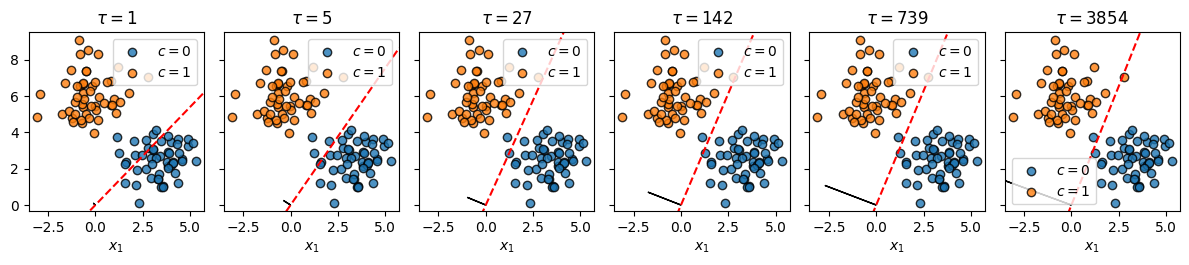

In [9]:
from activity3 import plot_decision_boundary_from_weights

tau_max = len(logistic_regression.w_)
taus = np.geomspace(1, tau_max-1, 6).round().astype(int)

_, axs = plt.subplots(1, 6, figsize=(12, 2.75), sharex=True, sharey=True, tight_layout=True)

for j, tau in enumerate(taus):
    axs[j].set_title(f'$\\tau={tau}$')
    scatter_data_by_target_value(x_train, y_train, ax=axs[j])
    plot_decision_boundary_from_weights(logistic_regression.w_[tau], ax=axs[j])
    axs[j].arrow(0, 0, *logistic_regression.w_[tau])
    axs[j].set_ylabel(None)

plt.show()

#### Task D: What do you notice about the optimisation process?

*The decision boundary is fixed very early and the majority of SGD iterations are just increasing the magnitude of the weights (leaving the direction unchanged).*

## Adding an Intercept

As we know from the previous activity, this dataset is not linearly seperable by a decision boundary that intersects the origin. To improve our fit, we can consider a model that also has an intercept term. We can do this again by forming a pipeline with an input transformation that adds a constant 1 variable.

In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

logistic_regression_intercept = make_pipeline(PolynomialFeatures(1), SGDLogisticRegressionClassifier(100, tau_max=100000, eta=0.02, random_state=0))
logistic_regression_intercept.fit(x_train, y_train)
lr_intercept_lr_part = logistic_regression_intercept.steps[1][1]
lr_intercept_lr_part.coef_

array([-16.00984633,  -6.12693738,   5.31082935])

Do you notice something about the fitted weights?

Let us again visualise the optimisation process to make this aspect even clearer. Note that the following cell can take around 20 seconds to complete (depending on your hardware).

In [11]:
feat_trans = logistic_regression_intercept.steps[0][1]

lrwi_train_log_losses = [log_loss(y_train, sigmoid(feat_trans.transform(x_train).dot(lr_intercept_lr_part.w_[tau]))) for tau in range(len(lr_intercept_lr_part.w_[::1]))]
lrwi_test_log_losses = [log_loss(y_test, sigmoid(feat_trans.transform(x_test).dot(lr_intercept_lr_part.w_[tau]))) for tau in range(len(lr_intercept_lr_part.w_[::1]))]
lrwi_train_01_losses = [zero_one_loss(y_train, (feat_trans.transform(x_train).dot(lr_intercept_lr_part.w_[tau])>1)) for tau in range(len(lr_intercept_lr_part.w_[::1]))]
lrwi_test_01_losses = [zero_one_loss(y_test, (feat_trans.transform(x_test).dot(lr_intercept_lr_part.w_[tau])>1)) for tau in range(len(lr_intercept_lr_part.w_[::1]))]

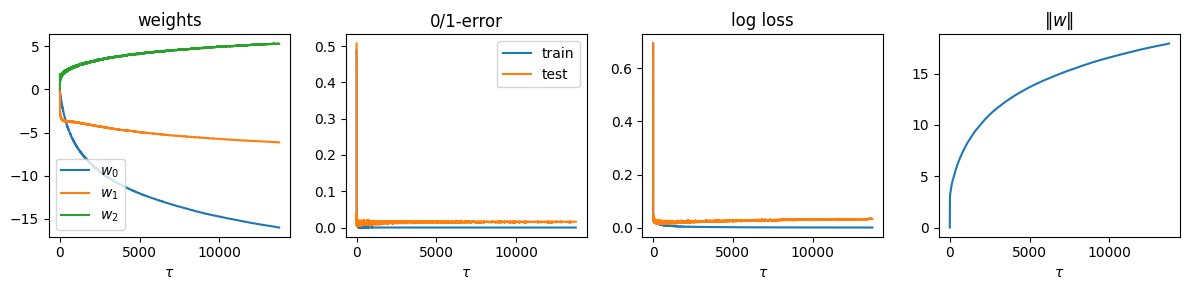

In [12]:
_, axs = plt.subplots(1, 4, tight_layout=True, figsize=(12, 3))

axs[0].set_title('weights')
axs[0].plot(lr_intercept_lr_part.w_[:, 0], label='$w_0$')
axs[0].plot(lr_intercept_lr_part.w_[:, 1], label='$w_1$')
axs[0].plot(lr_intercept_lr_part.w_[:, 2], label='$w_2$')
axs[0].legend()
axs[0].set_xlabel('$\\tau$')

axs[1].set_title('0/1-error')
axs[1].plot(lrwi_train_01_losses, label='train')
axs[1].plot(lrwi_test_01_losses, label='test')
axs[1].legend()
axs[1].set_xlabel('$\\tau$')

axs[2].set_title('log loss')
axs[2].plot(lrwi_train_log_losses, label='train')
axs[2].plot(lrwi_test_log_losses, label='test')
axs[2].set_xlabel('$\\tau$')

axs[3].set_title('$\|w\|$')
axs[3].plot(np.linalg.norm(lr_intercept_lr_part.w_, axis=1))
axs[3].set_xlabel('$\\tau$')
plt.show()

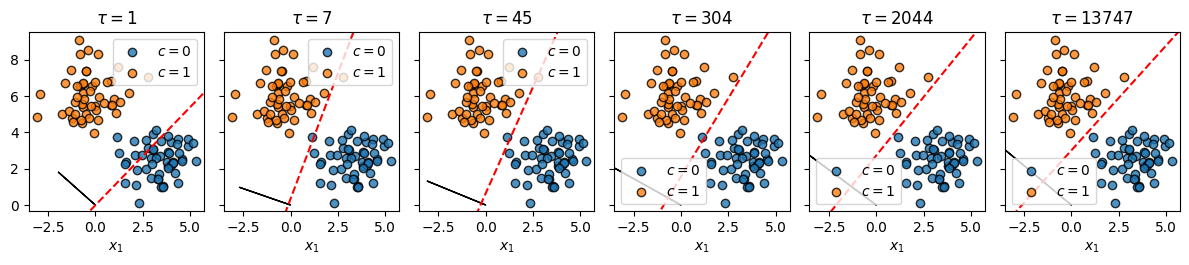

In [13]:
tau_max = len(lr_intercept_lr_part.w_)
taus = np.geomspace(1, tau_max-1, 6).round().astype(int)

_, axs = plt.subplots(1, 6, figsize=(12, 2.75), sharex=True, sharey=True, tight_layout=True)

for j, tau in enumerate(taus):
    axs[j].set_title(f'$\\tau={tau}$')
    scatter_data_by_target_value(x_train, y_train, ax=axs[j])
    plot_decision_boundary_from_weights(lr_intercept_lr_part.w_[tau], ax=axs[j])
    axs[j].arrow(0, 0, *lr_intercept_lr_part.w_[tau, 1:])
    axs[j].set_ylabel(None)

plt.show()

#### Task E: Describe the Optimisation Process

**What do you notice about the optimisation process now that the data is linearly separable? How can this problem be addressed?**

*For separable data, the error function can be driven arbitrary close to zero by stretching the weight vector to infinite magnitude. That means that a) the optimisaiton process will always run for a lot of iterations and b) that the model can be considered be ill-defined for separable data. This problem can be addressed by regularisation, which would force the optimal error to be attained for some weight vector with finite magnitude.*

## Adding Regularisation

As we did for linear regression, we can add a (squared) $2$-norm penalty to our error function to avoid an explosion of the fitted weights:
$$
E(\boldsymbol{w}) = \frac{\lambda}{2}\|\boldsymbol{w}\|^2_2 + \sum_{n=N} -t_n \ln y(\boldsymbol{x}_n) - (1-t_n) \ln (1- y(\boldsymbol{x}_n))
$$

With this the gradient becomes:
$$
\nabla E(\boldsymbol{w}) = \boldsymbol{X}^T(\sigma(\boldsymbol{X}\boldsymbol{w})-\boldsymbol{t}) + \lambda \boldsymbol{w}
$$

#### Task F: Implement the regularised gradient

**Complete line for gradient computation below**

In [14]:
class SGDRegularisedLogisticRegressionClassifier:

    def __init__(self, alpha=0.1, batch_size=10, eta=0.001, tau_max=10000, epsilon=0.00001, random_state=None):
        self.alpha = alpha
        self.eta = eta
        self.tau_max = tau_max
        self.epsilon = epsilon
        self.random_state = random_state
        self.batch_size = batch_size
        
    def fit(self, x, y):
        RNG = np.random.default_rng(self.random_state)
        n, p = x.shape
        self.w_ = np.zeros(shape=(self.tau_max+1, p))
        for tau in range(1, self.tau_max+1):
            idx = RNG.choice(n, size=self.batch_size, replace=True) 
            grad = (x[idx].T.dot(sigmoid(x[idx].dot(self.w_[tau-1]))-y[idx]) + self.alpha*self.w_[tau-1])
            self.w_[tau] = self.w_[tau-1] - self.eta*grad
            if np.linalg.norm(self.w_[tau]-self.w_[tau-1]) < self.epsilon:
                break
        self.coef_ = self.w_[tau] 
        self.w_ = self.w_[:tau+1]
        return self

    def decision_function(self, x):
        return x.dot(self.coef_)

    def predict(self, x):
        return (self.decision_function(x) > 0).astype(int)
    
    def predict_proba(self, x):
        p1 = sigmoid(self.decision_function(x))
        return np.column_stack((1-p1, p1))


Let us run and evaluate the regularised version.

In [15]:
reg_logistic_regression_intercept = make_pipeline(PolynomialFeatures(1), SGDRegularisedLogisticRegressionClassifier(alpha=0.1, batch_size=100, tau_max=100000, eta=0.0005))
reg_logistic_regression_intercept.fit(x_train, y_train)
reg_lr_intercept_lr_part = reg_logistic_regression_intercept.steps[1][1]
reg_lr_intercept_lr_part.coef_

array([-3.3224159 , -2.77512742,  1.74064254])

We can see that the weight vector is now much smaller. Let us close this activity with investigating the optimisation process and then summarising what we have learned.

Warning: the next cell can take about 30 seconds to execute.

In [16]:
feat_trans = reg_logistic_regression_intercept.steps[0][1]

rlrwi_train_log_losses = [log_loss(y_train, sigmoid(feat_trans.transform(x_train).dot(reg_lr_intercept_lr_part.w_[tau]))) for tau in range(len(reg_lr_intercept_lr_part.w_[::1]))]
rlrwi_test_log_losses = [log_loss(y_test, sigmoid(feat_trans.transform(x_test).dot(reg_lr_intercept_lr_part.w_[tau]))) for tau in range(len(reg_lr_intercept_lr_part.w_[::1]))]
rlrwi_train_01_losses = [zero_one_loss(y_train, (feat_trans.transform(x_train).dot(reg_lr_intercept_lr_part.w_[tau])>1)) for tau in range(len(reg_lr_intercept_lr_part.w_[::1]))]
rlrwi_test_01_losses = [zero_one_loss(y_test, (feat_trans.transform(x_test).dot(reg_lr_intercept_lr_part.w_[tau])>1)) for tau in range(len(reg_lr_intercept_lr_part.w_[::1]))]

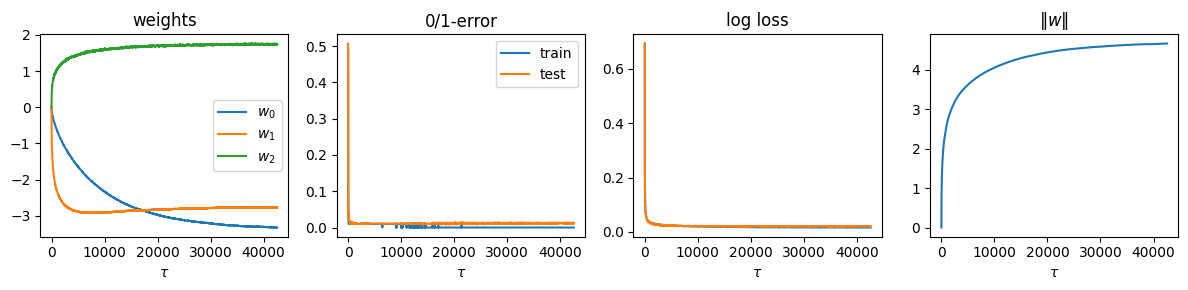

In [17]:
_, axs = plt.subplots(1, 4, tight_layout=True, figsize=(12, 3))

axs[0].set_title('weights')
axs[0].plot(reg_lr_intercept_lr_part.w_[:, 0], label='$w_0$')
axs[0].plot(reg_lr_intercept_lr_part.w_[:, 1], label='$w_1$')
axs[0].plot(reg_lr_intercept_lr_part.w_[:, 2], label='$w_2$')
axs[0].legend()
axs[0].set_xlabel('$\\tau$')

axs[1].set_title('0/1-error')
axs[1].plot(rlrwi_train_01_losses, label='train')
axs[1].plot(rlrwi_test_01_losses, label='test')
axs[1].legend()
axs[1].set_xlabel('$\\tau$')

axs[2].set_title('log loss')
axs[2].plot(rlrwi_train_log_losses, label='train')
axs[2].plot(rlrwi_test_log_losses, label='test')
axs[2].set_xlabel('$\\tau$')

axs[3].set_title('$\|w\|$')
axs[3].plot(np.linalg.norm(reg_lr_intercept_lr_part.w_, axis=1))
axs[3].set_xlabel('$\\tau$')
plt.show()

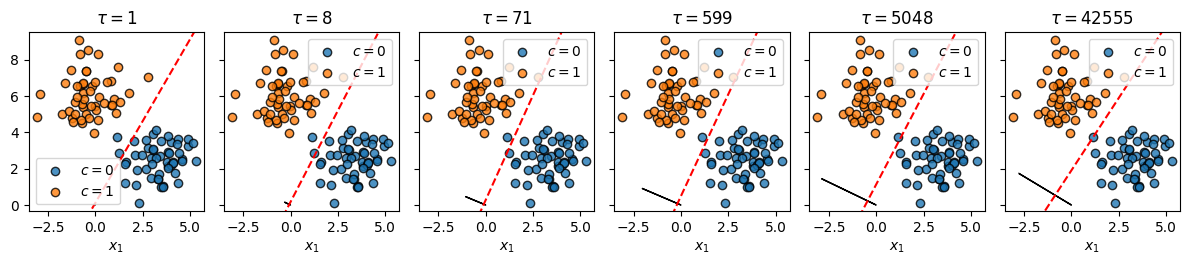

In [18]:
tau_max = len(reg_lr_intercept_lr_part.w_)
taus = np.geomspace(1, tau_max-1, 6).round().astype(int)

_, axs = plt.subplots(1, 6, figsize=(12, 2.75), sharex=True, sharey=True, tight_layout=True)

for j, tau in enumerate(taus):
    axs[j].set_title(f'$\\tau={tau}$')
    scatter_data_by_target_value(x_train, y_train, ax=axs[j])
    plot_decision_boundary_from_weights(reg_lr_intercept_lr_part.w_[tau], ax=axs[j])
    axs[j].arrow(0, 0, *reg_lr_intercept_lr_part.w_[tau, 1:])
    axs[j].set_ylabel(None)

plt.show()

# Summary

#### Task G: Summarise what you have learned 

**Summarise the key properties of logistic regression in comparison to the Perceptron algorithm**

- *The logistic loss is a convex is a differentiable and convex loss function that can be optimised with gradient descent*
- *It has a unique minimum if the training data is not linearly separable*

**Summarise the main disadvantage of plain logistic regression and it can be addressed**

- *If the data is linearly separable, the logistic loss does not have a minimum (diverges to infinity with growing weight vector norm)*
- *This can be addressed by regularisation. In particular, when using l2-regularisation, training error remains smooth and differentiable, thus can be built easily into gradient descent.*